# 2024Q2报告

使用em的业绩报告数据。

In [37]:
import pandas as pd
from scipy.stats import zscore
import akshare as ak
from jinja2 import Environment, FileSystemLoader
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib
import numpy as np
from IPython.display import HTML
import sqlite3
from pathlib import Path
import datetime
from uuid import uuid4
from scipy import stats
import time


In [2]:
# 解决matplotlib的中文问题
# bash中使用fc-list 找到family name
# plt.rcdefaults() # 样式调乱了，需要用它重置一下。
font_path = '/usr/share/fonts/truetype/wqy/wqy-microhei.ttc'
fm.fontManager.addfont(font_path)
# 设置全局字体为
matplotlib.rcParams['font.sans-serif'] = ['WenQuanYi Micro Hei']
matplotlib.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
plt.style.use('ggplot')

In [517]:
# def begin with plot, always use widedf
# def begin with draw, always use other df

def showProfile(df) :
    col_profile = pd.concat([df.dtypes, df.isna().sum()/len(df)*100, df.sample().T], axis=1 ).reset_index()
    col_profile.columns = ['列名', '类型', '缺失比%','样例']
    return (col_profile)

def plot_barh(df, title=None, fmt=''):
    """
    plot barh, x axis on top. If title not set, use df.columns[0] as title.
    """
    height = len(df)*25/72+0.5
    ax = df.plot.barh(figsize=(10, height), width=0.8, legend=False, zorder=3)
    ax.bar_label(ax.containers[0], label_type='edge', fmt=fmt)
    ax.xaxis.tick_top()
    title = title if title else df.columns[0]
    ax.set_title(title, fontsize=16, pad=20)
    
    plt.show(ax)

def df_cards(df, cols=None):
    """
    把df的每一行转化为html卡片形式。
    df: 整理好的DataFrame
    cols: 要展示的列名列表，需要在调用前进行修改。确定需要展示的样式：title, big, item, content等， 如果不提供，默认使用df的列名。
    """
    if not cols:
        cols = df.columns
    df.columns = [i for i in range(len(df.columns))]
    env = Environment(loader=FileSystemLoader('.'))
    template = env.get_template('cards.html')
    html_out = template.render(cols=cols, df=df)

    return HTML(html_out)

def plot_desc(df:pd.DataFrame):
    """
    x is time axis
    """
    df = df.T
    df = pd.concat([df.mean(), df.median(), df.max(), df.min()], axis=1)
    df.columns = ['mean', 'median', 'max', 'min']
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    df.iloc[:,[0,1]].plot(kind='line', ax=axs[0])
    df.iloc[:,[2,3]].plot(kind='line', ax=axs[1])
    plt.tight_layout()
    plt.show()

def plot_labs(df: pd.DataFrame, oneline:bool = False):
    """
    将df输出为包含三个值title, value, rank的标签。
    df: 二列或者三列，第一列为cname, 第二列为值，第三列可为其它数，如果没有第三列，则创建第三列为rank
    """
    uid = uuid4()
    if len(df.columns) == 2:
        df = df.reset_index(drop=True)
        df['rank'] = df.index+1
    codes = pd.read_csv('codes.csv', dtype={'code':'str'})[['cname', 'code']]
    df = df.merge(codes, on='cname')
    env = Environment(loader=FileSystemLoader('.'))
    template = env.get_template('lab.html')
    html_out = template.render(df=df, oneline = oneline, uid = uid)
    return HTML(html_out)

def plot_subs(df:pd.DataFrame, cols:int, kind:str = 'barh', sharex:bool = True, sharey:bool = True):
    """
    plot subplot.
    df: must be tidied, keep only data cols
    cols: how many columns in the subplots
    """
    s = df.shape
    rows = int(s[1]/cols)+1
    lay = (rows, cols)
    height = s[0]*0.3*rows
    axs = df.plot(kind=kind, subplots=True, layout=lay, figsize=(10,height), sharex=sharex, sharey=True, fontsize=8, legend=False)
    plt.tight_layout()  # 调整子图布局，避免重叠
    plt.show()

def plot_muti_lines(df: pd.DataFrame, logy:bool = False):
    """
    multiline chart
    legend order by last column, and in left side.
    """
    height = max(0.3*len(df.T), 5)
    ax = df.plot.line(figsize=(10, height), logy=logy)
    handles, labels = ax.get_legend_handles_labels()
    # h = list(df.iloc[-1].sort_values(ascending=False).index.values)
    ol = list(df.iloc[-1].sort_values(ascending=False).index.values)
    oh = [handles[labels.index(label)] for label in ol]
    ax.legend(oh, ol, loc='upper left')
    plt.show(ax)

def plot_cdf(df:pd.DataFrame, col:int = -1, logx : bool = False):
    x = df.iloc[col, :].sort_values()
    y = np.linspace(0, 1, len(x))
    fig, ax = plt.subplots(figsize=(10, 5))

    ax.plot(x, y)
    if logx:
        ax.set_xscale('log')  # 设置 x 轴为对数轴
    ax.twinx().set_ylim(0, len(x))

    plt.show()

def plot_total_change(df:pd.DataFrame, fmt:str = '{:.2f}'):
    """
    df: index is year, columns is cname.
    return barh with 2 axes.
    share y axis which is year.
    x axis is total, pct change.
    """
    height = 0.3*len(df)+1
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, height), sharey=True)
    df.T.sum().plot.barh(ax=ax1, width=0.8, title='Total')
    df.T.sum().pct_change().plot.barh(width=0.8, title = 'Pct Change')
    ax1.bar_label(ax1.containers[0], fmt=fmt)
    ax2.bar_label(ax2.containers[0], fmt='{:.2%}')
    plt.tight_layout()
    plt.show()

def draw_vhists(df:pd.DataFrame, bins:int = 14, fig_cols:int =3):
    """
    df: must be tidied, keep only numeric data cols only.
    fig_cols: how many columns in the subplots
    """
    def divide_or_ceil(a:int, b:int):
        if a % b == 0:
            return a // b
        else:
            return (a // b) + 1
    df_cols = len(df.columns)
    rows = divide_or_ceil(df_cols, fig_cols)
    height = 0.3*bins*rows+1
    fig, axs = plt.subplots(rows, fig_cols, figsize=(10,height))
    axs = axs.flatten()
    for i in range(df_cols):
        axs[i].hist(df.iloc[:,i], bins=bins, edgecolor='white', linewidth=1.2, orientation='horizontal')
        axs[i].set_title(df.columns[i])
    plt.tight_layout()  # 调整子图布局，避免重叠
    plt.show()

def cross_dfs(df:pd.DataFrame, to_cross:list):
    """
    求出若干个df的交集，每个df都有cname列。
    """
    res = set(df['cname'])
    for d in to_cross:
        res &= set(d['cname'])
    ret_df = df[df['cname'].isin(res)]
    return ret_df

def de_banks(df:pd.DataFrame):
    ret = df[~df['cname'].str.contains(r'银行|商行|证券')]
    print(f'total: {len(df)} | banks: {len(df)-len(ret)} | non-banks: {len(ret)}')
    return ret

def get_slope(s:pd.Series):
    y = s.dropna().values  # y 值为序列的值
    x = np.arange(len(y))  # x 值为序列的索引
    coefficients = np.polyfit(x, y, 1)
    slope = coefficients[0]
    intercept = coefficients[1]
    # 计算残差
    y_pred = slope * x + intercept
    residuals = y - y_pred
    # 计算残差的标准差（Residual Standard Error）
    residual_std_dev = np.std(residuals)
    ret = slope / (residual_std_dev + 1e-10)  # 避免除以零
    return ret

def cross_index(ss):
    crossed = set(ss[0].index)
    for s in ss[1:]:
        crossed = crossed & set(s.index)
    return ss[0].loc[list(crossed)]

def timing_decorator(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"{func.__name__} took {end_time - start_time:.6f} seconds to run.")
        return result
    return wrapper

In [438]:
class YJBB:
    ALL_COLS = ['序号', '股票代码', '股票简称', '每股收益', '营业收入-营业收入', '营业收入-同比增长', '营业收入-季度环比增长', '净利润-净利润', '净利润-同比增长', '净利润-季度环比增长', '每股净资产', '净资产收益率', '每股经营现金流量', '销售毛利率', '所处行业', '最新公告日期']
    
    def __init__(self):
        self.codedf = self.get_codes()
        self.code_dict = self.get_code_dict()
        self.df = self.get_valid_reports()
        self.indu_dict = self.df.groupby('cname', observed=True)['industry'].first().to_dict()
        self.tidied = self.tidy_all()

    def get_data(self):
        cols = ['股票代码', '股票简称', '营业收入-营业收入','净利润-净利润', '所处行业', 'rdate']
        cols_str = ', '.join([f'"{col}"' if '-' in col else col for col in cols])
        conn = sqlite3.connect('../yjbb.db')
        df = pd.read_sql_query(f'select {cols_str} from yjbb_data', conn)
        conn.close()
        df.columns = ['code', 'cname', 'revenue', 'profit', 'industry', 'rdate']
        # qs = {'1231': 'Q4', '0331': 'Q1', '0630': 'Q2', '0930': 'Q3'}
        # df['rdate'] = df['rdate']
        df = df.astype({
            # 'code': 'category',
            'cname': 'category',
            'industry': 'category',
            'rdate': 'category'
        })
        df.replace(0, np.nan, inplace=True)

        return df
    
    def get_codes(self):
        current_time = datetime.datetime.now().timestamp()
        codes = Path('codes.csv')
        if codes.exists() :
            diff = current_time - codes.stat().st_mtime
            if diff < 3600*24:
                df = pd.read_csv(codes, dtype={'code': str})
                return df
        df = ak.stock_zh_a_spot_em()[['代码', '名称','市盈率-动态', '市净率', '总市值']]
        df.columns = ['code', 'cname', 'pe', 'pb', 'mv']
        df.to_csv(codes, index=False)
        return df
    
    def get_valid_reports(self):
        """
        报告df中含有新三板的数据，不需要用。
        codedf中含有退市的代码，这些代码没有报告。
        报告数据使用这两者的交集。
        """
        df = self.get_data()
        report_codes = df['code'].unique()
        trade_codes = self.codedf['code'].unique()
        crossed_codes = set(report_codes) & set(trade_codes)
        df = df.loc[df['code'].isin(crossed_codes)]
        return df
    
    def get_code_dict(self):
        codes = self.codedf
        codes['link'] = codes['code'] + codes['cname']
        codes['link'] = codes['link'].apply(lambda x: f'<a href="https://data.eastmoney.com/stockdata/{x[0:6]}.html" target="_blank">{x[6:]}</a>')
        code_dict = codes.set_index('cname')['link'].to_dict()
        return code_dict
    
    def tidy_all(self):
        """
        按季度整理数据，使收入和利润可以进行按季度进行比较。
        em的数据，目前看只有profit和revenue具有可用性。所以只整理这两项。
        可供分析的再加上一个计算得来的利润率。
        """
        def tidy_data(df:pd.DataFrame, item : str):
            """
            按季度整理数据，使收入和利润可以进行按季度进行比较。
            """
            dft = df.pivot_table(index='rdate', columns='code', values=item, aggfunc='first', observed=True)
            long, wide = dft.shape
            display(f'{item} 代码总数: {wide}')
            nan_count_s = dft.isna().sum()
            display(f'数据齐全: {len(nan_count_s[nan_count_s==0])}')
            to_tidy_s = nan_count_s[nan_count_s > 0].index
            display(f'需要整理: {len(to_tidy_s)}')
            # 将有空值的code从最近一期往前数，找到第一个空值的索引
            to_tidy_df = dft.loc[:, to_tidy_s].sort_index(ascending=False)
            first_null_index_s  = to_tidy_df.reset_index(drop=True).isna().idxmax()
            # 小于7期的设为全空，可以去掉。
            first_null_index_s = first_null_index_s.apply(lambda x: x if x >7 else 0)
            # 将第一个空索引号及以前期的数据设为空值，就得到了连续报告期的数量。
            mask = pd.DataFrame({k: [True] * v + [False] * (long - v) for k, v in first_null_index_s.items()})
            mask.index = to_tidy_df.index
            tided_df = to_tidy_df[mask].dropna(how='all', axis=1).sort_index()
            display(f'删除连续数据少于8期: {len(to_tidy_df.T)-len(tided_df.T)}')
            tided_df = pd.concat([dft.loc[:, nan_count_s[nan_count_s == 0].index], tided_df], axis=1)
            display(f'完成整理后总数: {len(tided_df.T)}')
            #原来的季报数据为当年加总，转换为单季度数据。
            to_diff_df = tided_df.reset_index(drop=True)
            diffed_df = to_diff_df.groupby(to_diff_df.index // 4).diff().fillna(to_diff_df)
            diffed_df.index = tided_df.index
            # 4个季度滚动相加做为季度化的年度数据，从而进行季度对比。
            rolled_df = diffed_df.rolling(4).sum().dropna(how='all')
            ret = rolled_df.melt(value_name=item, ignore_index=False).reset_index()
            display(f'{item} tidy complete!')
            return ret
        
        df = self.df
        profit = tidy_data(df, 'profit')
        revenue = tidy_data(df, 'revenue')
        crossed = set(profit['code'].unique()) - set(revenue['code'].unique())
        display(f'删除有利润无收入的（基本为科创板）: {crossed}')
        profit = profit.loc[~profit['code'].isin(list(crossed))]
        display(f'profit len: {len(profit)} | revenue len: {len(revenue)}')
        ret = profit.merge(revenue, on=['code', 'rdate'], how='left')
        ret['npm'] = ret['profit'] / ret['revenue']
        ret.to_pickle('keydata.pkl')
        code_cname_dict = self.codedf.set_index('code')['cname'].to_dict()
        ret['cname'] = ret['code'].apply(lambda x: code_cname_dict[x])

        return ret

    def get_mostn(self, df:pd.DataFrame, n:int=300, ascending:bool = False):
        """
        input df: widedf, index by year.
        return df: any cname appeared in top n in any year.
        num: how many times appeared.
        tnum: total reports.
        pct: hit times of total reports.
        """
        mostn_per_year = df.T.apply(lambda x: x.sort_values(ascending=ascending).head(n).index)
        mostn_all = mostn_per_year.melt()['value'].value_counts().to_frame('hits')
        total_reports = df.count().to_frame('total')
        mostn_all = mostn_all.merge(total_reports, left_index=True, right_index=True)
        mostn_all['pct'] = mostn_all['hits'] / mostn_all['total']
        mostn_all = mostn_all.sort_values(by=['pct', 'total'], ascending=[ascending, ascending])
        return (mostn_per_year, mostn_all)
    
    def mostn_by_func(self, df:pd.DataFrame, mostn:int = 300, ascending:bool = False, no_sum:bool = False):
        # for func in ['sum', 'mean', 'median', 'min', 'max']:
        funcs = ['mean', 'median', 'min', 'max'] if no_sum else ['sum', 'mean', 'median', 'min', 'max']
        res = [ df.agg(func).sort_values(ascending=ascending).to_frame(func).head(mostn).index.values for func in funcs]
        ret = pd.DataFrame(res).T
        ret.columns = funcs
        ret = ret.map(lambda x: self.code_dict[x]).style
        return ret
    
    def gt_all_years(sefl, df:pd.DataFrame, low:int = 10, high:int = 16):
        """
        find all companies that have been greater than n in all years
        """
        res = pd.DataFrame({
            n: (df > n).sum() for n in range(low, high)
        })
        total_s = df.count()
        res = res[res.apply(lambda x : x == total_s)]
        cols = [f'{v} gt {k}' for k, v in res.count().items()]
        res.columns = cols
        res.index = res.index.map(lambda x: yjbb.code_dict[x])
        res = res.sort_values(by=cols[0], ascending=False)
        return res
    
    def gt_per_year(self, df:pd.DataFrame, n:int = 15):
        """
        plot barh of count of companies that have been greater than n in each year
        """
        s = (df > n).sum(axis=1)
        total = df.count(axis=1)
        res = s.to_frame(f'count great than {n}')
        res['pct'] = res[f'count great than {n}'] / total
        plot_subs(res,2, sharex=False)

    def fold_a_col(self, s:pd.Series, n:int = 10, show_num:bool = True, fmt = '{:.2f}'):
        """
        fold a column into n columns
        input series must be indexed by cname, and values are numbers
        output: cname + value in every cell
        """
        df = s.dropna().sort_values(ascending=False).to_frame()
        if show_num:
            df['cname'] = df.index.map(lambda x: self.code_dict[x]) + ' ' + df.iloc[:,-1].map(lambda x: fmt.format(x))
        else:
            df['cname'] = df.index.map(lambda x: self.code_dict[x])
        df['group'] = [i % n for i in range(len(df))]
        folded = pd.concat([g.reset_index(drop=True)[['cname']] for _, g in df.groupby('group')], axis=1)
        # 如果数量很少，不够10列显示，则有几个算几列。
        col_name = len(df) if len(df) < n else n
        folded.columns = [i+1 for i in range(col_name)]
        folded.replace(np.nan, '', inplace=True)
        print(f'total: {len(df)} | from {round(df.iloc[:,0].max(), 2)} to {round(df.iloc[:,0].min(), 2)}')
        return folded.style
    
    def indu_count(self, s:pd.Series, n:int = 20):
        indu = s.map(lambda x: self.indu_dict[x])
        indu_count = indu.value_counts().sort_values(ascending=True)
        print(f'total: {len(indu_count)} | top {n} : {indu_count.tail(n).sum() / indu_count.sum() * 100:.2f}%')
        plot_barh(indu_count.tail(n).to_frame('count'))


yjbb = YJBB()

'profit 代码总数: 5378'

'数据齐全: 2045'

'需要整理: 3333'

'删除连续数据少于8期: 72'

'完成整理后总数: 5306'

'profit tidy complete!'

'revenue 代码总数: 5378'

'数据齐全: 2015'

'需要整理: 3363'

'删除连续数据少于8期: 76'

'完成整理后总数: 5302'

'revenue tidy complete!'

"删除有利润无收入的（基本为科创板）: {'688382', '688192', '688302', '688197'}"

'profit len: 291610 | revenue len: 291610'

In [458]:
df = yjbb.tidied

In [440]:
showProfile(yjbb.tidied)

,列名,类型,缺失比%,样例
0,rdate,category,0.000000,20230331
1,code,object,0.000000,002039
2,profit,float64,33.917904,311095925.49
3,revenue,float64,34.128459,2274167525.18
4,npm,float64,34.128459,0.136796
5,cname,object,0.000000,黔源电力


In [ ]:
def loss_pct(df:pd.DataFrame):
    profit = df.pivot_table(index='rdate', columns='code', values='profit', observed=True)
    # count_s = profit.count(axis=1)
    count_pct_s = (profit < 0).mean(axis=1) # 一条命令计算亏损家数的比例
    # count_pct_s = count_neg_s / count_s
    posi_value_s = profit[profit > 0].sum(axis=1)
    total_value_s = profit.sum(axis=1)
    value_pct_s = (posi_value_s - total_value_s) / posi_value_s
    res  = pd.DataFrame([count_pct_s, value_pct_s], index=['count', 'value']).T
    plot_muti_lines(res)

In [574]:
def tops(df:pd.DataFrame, n:int, col:str):
    sel = df[['rdate', 'cname', col]]
    total_qs_s = sel.dropna()['cname'].value_counts().to_frame('total')
    mostn_s = sel.sort_values(['rdate', col], ascending=[1, 0]).groupby('rdate', observed=True)[['cname', col]].nth[:n]['cname'].value_counts().sort_values(ascending=0)
    mostn_df = mostn_s.to_frame('hits')
    mostn_df = mostn_df.join(total_qs_s)
    mostn_df['pct'] = mostn_df['hits'] / mostn_df['total']
    mostn_df['item'] = col
    mostn_df = mostn_df.reset_index(names='cname')
    any_q = mostn_df.set_index('cname')['hits']
    all_q = mostn_df[mostn_df['pct'] >=1].set_index('cname')['hits']
    dft = df.pivot_table(index='rdate', columns='cname', values='profit', observed=True)
    # 20期以上的从第20期向后逐年计算slop,最后计算平均。
    slop = pd.concat(
        [dft.iloc[:i,:].dropna(thresh=20, axis=1).apply(get_slope) for i in range(20, len(dft))],
        axis=1
    ).mean(1).nlargest(n)
    slop_cross_any_q = slop[list(set(any_q.index.values) & set(slop.index.values))]
    slop_cross_all_q = slop[list(set(all_q.index.values) & set(slop.index.values))]
    
    def topn_s():
        display(f'------所有上过榜的------')
        display(yjbb.fold_a_col(any_q,fmt='{:.0f}'))
        display(f'------每期都上榜的------')
        display(yjbb.fold_a_col(all_q, show_num=False))

    def slop_s():
        display('------增长情况------')
        display(f'增长top{n}')
        display(yjbb.fold_a_col(slop,fmt='{:.2f}'))

        display(f'增长top{n},同时上榜过{col} top{n}')
        if len(slop_cross_any_q)>0:
            display(yjbb.fold_a_col(slop_cross_any_q,fmt='{:.2f}'))
        else: display('无交集')

        display(f'增长top{n},同时{col}一直top{n}')
        if len(slop_cross_any_q)>0:
            display(yjbb.fold_a_col(slop_cross_all_q,fmt='{:.2f}'))
        else: display('无交集')

    return (mostn_df, topn_s, slop_s)

In [ ]:
def totals(df:pd.DataFrame):
    # get sum of [revenue, profit, asset, cash] of each year
    sum_df = df.groupby('rdate', observed=True)[['revenue', 'profit']].sum()
    plot_muti_lines(sum_df, logy=True)
    plot_muti_lines(sum_df.pct_change(), logy=False)
    sum_df['npm'] = sum_df['profit'] / sum_df['revenue'] * 100
    # sum_df['roe'] = sum_df['profit'] / sum_df['asset'] * 100
    plot_muti_lines(sum_df[['npm']], logy=False)

## 金额

### 总体情况

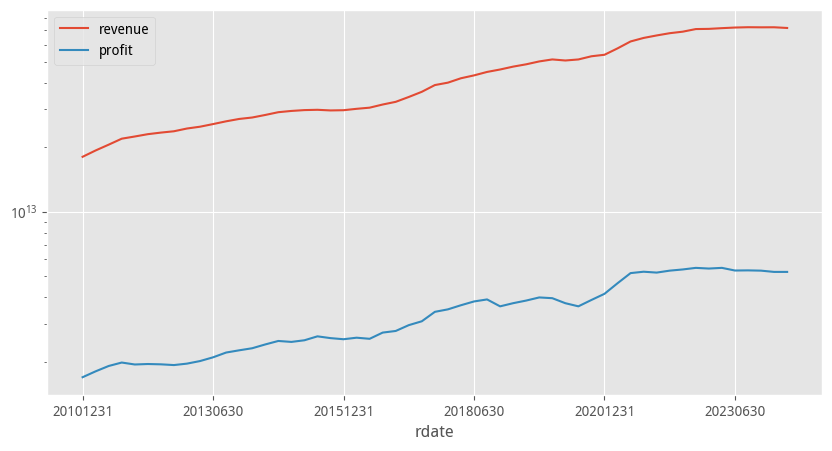

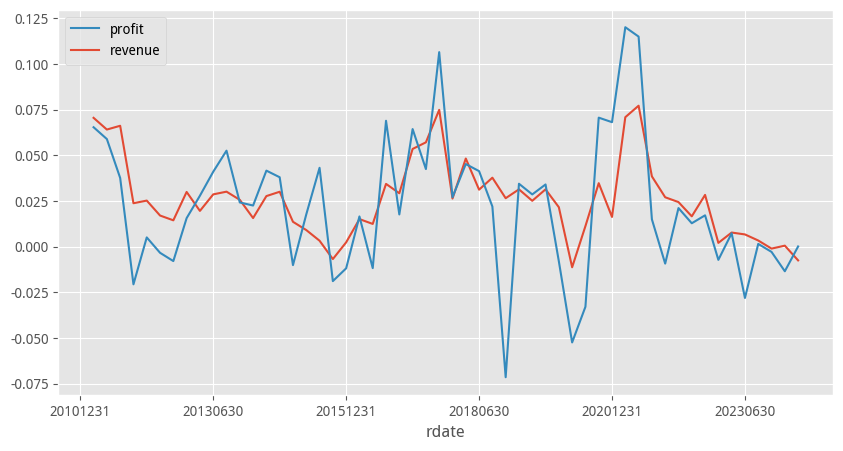

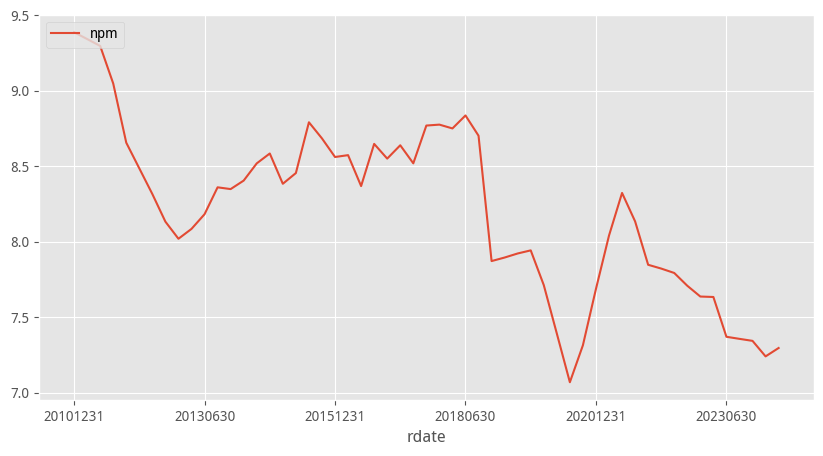

In [367]:
totals(yjbb.tidied)

- 总收入还在小幅度增长，但总利润已经开始下降。考虑到前三年上市高峰期，利润的减少实际更严重。
- 利润增长率本季同比为负数。历史上仅疫情第一季出现这种情况。
- 全市场净利率连续第3年同比下滑，但没有下降在2020年的低点。

### 亏损情况

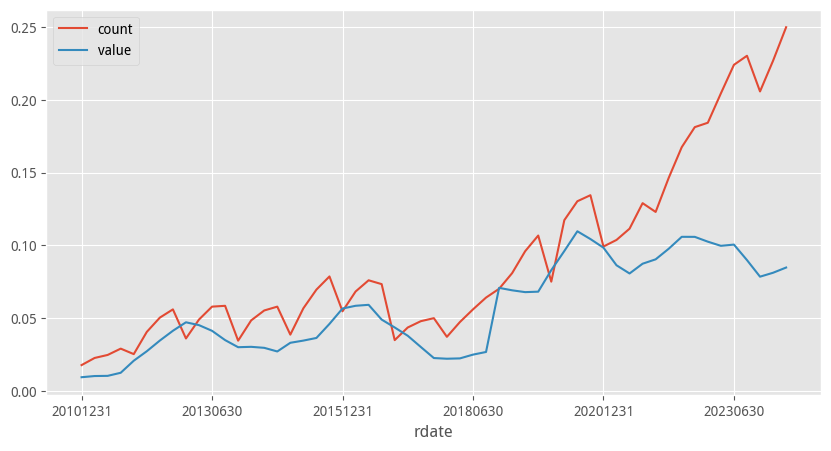

In [368]:
loss_pct(yjbb.tidied)

- 亏损家数和金额都在2020年达到历史高点。但2021年又快速回落。
- 亏损家数的比例远大于亏损金额的比例，说明小企业亏损的比例更高。
- 就亏损金额占比而言，2023年Q1显示出下降，但全年令人失望。
- 2024年Q1亏损金额占比又开始回升了。不好的预期。

## 排名

In [378]:
df = yjbb.tidied

### 最近一年各项指标前20

In [575]:
top30 = tops(df, 30, 'revenue')

In [577]:
top30[1]()

'------所有上过榜的------'

total: 60 | from 55 to 1


,1,2,3,4,5,6,7,8,9,10
0,中国石化 55,中国石油 55,中国中铁 55,中国铁建 55,中国人寿 55,工商银行 55,中国建筑 55,上汽集团 55,建设银行 55,农业银行 55
1,中国银行 55,中国交建 55,中国电信 55,中国中冶 55,中国平安 55,中国电建 55,中国太保 47,宝钢股份 47,万 科Ａ 45,江西铜业 44
2,中国联通 42,物产中大 40,绿地控股 37,中国神华 37,美的集团 36,招商银行 32,建发股份 28,工业富联 28,交通银行 27,中国人保 26
3,厦门象屿 19,中国铝业 19,新华保险 18,五矿发展 16,海航科技 16,厦门国贸 16,华能国际 15,中国中车 14,邮储银行 14,中国移动 13
4,中国能建 11,河钢股份 10,民生银行 9,中国海油 9,比亚迪 7,宁德时代 6,兴业银行 6,太钢不锈 5,中国国航 5,中远海控 4
5,ST易购 4,浦发银行 4,鞍钢股份 3,格力电器 3,上海石化 2,石化油服 2,新 希 望 1,中国长城 1,山煤国际 1,金龙鱼 1


'------每期都上榜的------'

total: 19 | from 55 to 13


,1,2,3,4,5,6,7,8,9,10
0,中国石化,中国石油,中国中铁,中国铁建,中国人寿,工商银行,中国建筑,上汽集团,建设银行,农业银行
1,中国银行,中国交建,中国电信,中国中冶,中国平安,中国电建,工业富联,中国人保,中国移动,


In [578]:
top30[2]()

'------增长情况------'

'增长top30'

total: 30 | from 0.93 to 0.55


,1,2,3,4,5,6,7,8,9,10
0,宁波银行 0.93,心脉医疗 0.93,迈瑞医疗 0.93,唐山港 0.89,同仁堂 0.84,中国建筑 0.83,安图生物 0.80,胜宏科技 0.78,恩华药业 0.77,柯力传感 0.74
1,汉得信息 0.69,南京银行 0.69,中微公司 0.69,普门科技 0.67,光威复材 0.67,中国电研 0.67,联环药业 0.64,盘龙药业 0.63,青鸟消防 0.63,齐鲁银行 0.62
2,健友股份 0.62,亿联网络 0.62,长沙银行 0.60,北京银行 0.60,珀莱雅 0.60,迈为股份 0.59,东阿阿胶 0.59,比音勒芬 0.59,海康威视 0.55,中国铁建 0.55


'增长top30,同时上榜过revenue top30'

total: 2 | from 0.83 to 0.55


,1,2
0,中国建筑 0.83,中国铁建 0.55


'增长top30,同时revenue一直top30'

total: 2 | from 0.83 to 0.55


,1,2
0,中国建筑 0.83,中国铁建 0.55


- 收入巨头出现了一个新贵，比BYD。

### 历年进入过前300

In [579]:
top300 = tops(df, 300, 'revenue')

In [581]:
top300[1]()

'------所有上过榜的------'

total: 556 | from 55 to 1


,1,2,3,4,5,6,7,8,9,10
0,云天化 55,南方航空 55,中远海控 55,中国国航 55,浦发银行 55,万 科Ａ 55,中集集团 55,TCL科技 55,铜陵有色 55,新 希 望 55
1,福田汽车 55,中国重工 55,民生银行 55,中信银行 55,华菱钢铁 55,京东方Ａ 55,海大集团 55,大唐发电 55,格力电器 55,上海电气 55
2,华谊集团 55,锡业股份 55,万华化学 55,柳钢股份 55,一汽解放 55,新兴铸管 55,东方电气 55,上海医药 55,中化国际 55,包钢股份 55
3,国电电力 55,四川长虹 55,上海石化 55,华电国际 55,本钢板材 55,比亚迪 55,云南铜业 55,中联重科 55,长安汽车 55,三一重工 55
4,厦门国贸 55,中国化学 55,海螺水泥 55,国机汽车 55,兖矿能源 55,新钢股份 55,光大银行 55,保利发展 55,广汽集团 55,广州发展 55
5,华东医药 55,海亮股份 55,中信证券 55,首钢股份 55,安阳钢铁 55,紫金矿业 55,伊利股份 55,江淮汽车 55,南钢股份 55,山东钢铁 55
6,中国中免 55,通威股份 55,云南白药 55,金发科技 55,大秦铁路 55,兴业银行 55,华域汽车 55,物产中大 55,远大控股 55,海信视像 55
7,温氏股份 55,长江电力 55,中金黄金 55,金隅集团 55,华锦股份 55,贵州茅台 55,永辉超市 55,粤电力Ａ 55,国药一致 55,老凤祥 55
8,双汇发展 55,华夏银行 55,厦门象屿 55,徐工机械 55,五 粮 液 55,金风科技 55,海信家电 55,特变电工 55,平安银行 55,西部矿业 55
9,恒逸石化 55,中储股份 55,杭钢股份 55,金地集团 55,北京银行 55,荣盛石化 55,爱施德 55,厦门信达 55,天音控股 55,九州通 55


'------每期都上榜的------'

total: 186 | from 55 to 8


,1,2,3,4,5,6,7,8,9,10
0,中国石化,中国石油,中国中铁,中国铁建,江西铜业,ST易购,上海建工,中国东航,招商银行,中煤能源
1,中兴通讯,建发股份,中国中车,马钢股份,海尔智家,潍柴动力,上海电气,格力电器,大唐发电,海大集团
2,京东方Ａ,华菱钢铁,中信银行,民生银行,中国重工,福田汽车,新 希 望,铜陵有色,TCL科技,中集集团
3,万 科Ａ,浦发银行,比亚迪,本钢板材,华电国际,上海石化,四川长虹,国电电力,包钢股份,中化国际
4,上海医药,东方电气,新兴铸管,一汽解放,柳钢股份,万华化学,锡业股份,华谊集团,海亮股份,华东医药
5,广州发展,广汽集团,保利发展,光大银行,新钢股份,兖矿能源,国机汽车,海螺水泥,中国化学,厦门国贸
6,三一重工,长安汽车,中联重科,云南铜业,物产中大,华域汽车,兴业银行,大秦铁路,金发科技,云南白药
7,通威股份,中国中免,山东钢铁,南钢股份,江淮汽车,伊利股份,紫金矿业,安阳钢铁,首钢股份,中信证券
8,徐工机械,厦门象屿,华夏银行,双汇发展,老凤祥,国药一致,粤电力Ａ,永辉超市,贵州茅台,华锦股份
9,金隅集团,中金黄金,长江电力,温氏股份,海信视像,远大控股,九州通,天音控股,厦门信达,爱施德


In [582]:
top300[2]()

'------增长情况------'

'增长top300'

total: 300 | from 0.93 to 0.26


,1,2,3,4,5,6,7,8,9,10
0,宁波银行 0.93,心脉医疗 0.93,迈瑞医疗 0.93,唐山港 0.89,同仁堂 0.84,中国建筑 0.83,安图生物 0.80,胜宏科技 0.78,恩华药业 0.77,柯力传感 0.74
1,汉得信息 0.69,南京银行 0.69,中微公司 0.69,普门科技 0.67,光威复材 0.67,中国电研 0.67,联环药业 0.64,盘龙药业 0.63,青鸟消防 0.63,齐鲁银行 0.62
2,健友股份 0.62,亿联网络 0.62,长沙银行 0.60,北京银行 0.60,珀莱雅 0.60,迈为股份 0.59,东阿阿胶 0.59,比音勒芬 0.59,海康威视 0.55,中国铁建 0.55
3,景津装备 0.55,平安银行 0.55,美亚光电 0.55,航天电器 0.54,老百姓 0.54,金牌家居 0.53,信质集团 0.53,中文传媒 0.52,威胜信息 0.52,富安娜 0.52
4,伊利股份 0.52,机器人 0.51,正海生物 0.51,皇马科技 0.50,新华文轩 0.50,启迪环境 0.50,兴业银行 0.50,利安隆 0.49,成都银行 0.49,龙软科技 0.48
5,常熟银行 0.48,浦发银行 0.48,海天味业 0.47,欧派家居 0.47,广和通 0.47,密尔克卫 0.47,奇正藏药 0.47,特宝生物 0.46,龙净环保 0.46,我武生物 0.46
6,招商银行 0.46,信立泰 0.45,美的集团 0.45,林洋能源 0.45,艾德生物 0.45,中电环保 0.45,诺力股份 0.45,七一二 0.44,欧普康视 0.44,新城控股 0.44
7,中原内配 0.44,安集科技 0.43,良信股份 0.43,老凤祥 0.43,凌霄泵业 0.43,久远银海 0.43,铂科新材 0.43,益丰药房 0.43,基康仪器 0.42,科锐国际 0.42
8,阿拉丁 0.42,伟星新材 0.42,中科软 0.42,航民股份 0.42,大华股份 0.41,康龙化成 0.41,杭州银行 0.41,联瑞新材 0.41,江苏金租 0.41,柏楚电子 0.40
9,柳药集团 0.40,金山办公 0.40,麦格米特 0.40,云南白药 0.40,芯源微 0.40,红日药业 0.40,苏农银行 0.40,三角防务 0.39,深南电路 0.39,正泰电器 0.39


'增长top300,同时上榜过revenue top300'

total: 58 | from 0.93 to 0.26


,1,2,3,4,5,6,7,8,9,10
0,宁波银行 0.93,迈瑞医疗 0.93,中国建筑 0.83,南京银行 0.69,北京银行 0.60,海康威视 0.55,中国铁建 0.55,平安银行 0.55,中文传媒 0.52,伊利股份 0.52
1,兴业银行 0.50,浦发银行 0.48,海天味业 0.47,招商银行 0.46,美的集团 0.45,新城控股 0.44,老凤祥 0.43,大华股份 0.41,杭州银行 0.41,云南白药 0.40
2,正泰电器 0.39,上海银行 0.39,上海医药 0.38,万 科Ａ 0.37,华夏银行 0.36,国药一致 0.36,白云山 0.36,中国中铁 0.35,江苏银行 0.35,欧亚集团 0.35
3,中国核建 0.34,恒瑞医药 0.34,复星医药 0.33,保利发展 0.33,国联股份 0.33,隧道股份 0.33,华东医药 0.33,光大银行 0.32,深圳燃气 0.31,农业银行 0.31
4,华夏幸福 0.31,格力电器 0.31,上海建工 0.31,中国银行 0.30,中国医药 0.30,建设银行 0.30,康美药业 0.30,中国外运 0.29,华域汽车 0.29,中直股份 0.29
5,药明康德 0.29,国药股份 0.28,中国平安 0.28,武商集团 0.28,中国中免 0.27,上汽集团 0.27,海尔智家 0.27,海亮股份 0.26,,


'增长top300,同时revenue一直top300'

total: 36 | from 0.83 to 0.26


,1,2,3,4,5,6,7,8,9,10
0,中国建筑 0.83,北京银行 0.60,中国铁建 0.55,平安银行 0.55,伊利股份 0.52,兴业银行 0.50,浦发银行 0.48,招商银行 0.46,美的集团 0.45,新城控股 0.44
1,老凤祥 0.43,云南白药 0.40,上海银行 0.39,上海医药 0.38,万 科Ａ 0.37,华夏银行 0.36,国药一致 0.36,中国中铁 0.35,江苏银行 0.35,中国核建 0.34
2,保利发展 0.33,隧道股份 0.33,华东医药 0.33,光大银行 0.32,农业银行 0.31,格力电器 0.31,上海建工 0.31,中国银行 0.30,建设银行 0.30,中国外运 0.29
3,华域汽车 0.29,中国平安 0.28,中国中免 0.27,上汽集团 0.27,海尔智家 0.27,海亮股份 0.26,,,,


- 四个指标都进入过前300强的有311家。
- 收入巨头最稳定，而现金巨头最不稳定。

### 每年都进入前300

- 每年都能进入前300的，每个指标都不多。
- 最难保持进入的是现金的榜单。净资产巨头每年上榜的最多。

## 增长情况
- 选择了有6期以上报告的公司。用斜率除以残余标准差来衡量增长情况。

,revenue,profit,asset,cash
0,英特集团,中国建筑,中牧股份,复星医药
1,东方国信,唐山港,华润双鹤,中国国贸
2,云南白药,南京银行,民生银行,鲁北化工
3,圣农发展,招商银行,交通银行,恩华药业
4,丽珠集团,大华股份,浦发银行,太阳纸业
5,兴森科技,联环药业,贵航股份,康缘药业
6,上海医药,美的集团,深圳燃气,渤海租赁
7,健康元,伊利股份,洋河股份,长电科技
8,洽洽食品,索菲亚,明星电力,安科生物
9,招商银行,兴蓉环境,兴业银行,TCL科技


slope top 300 no cash: 64
total: 29 | top 20 : 85.94%


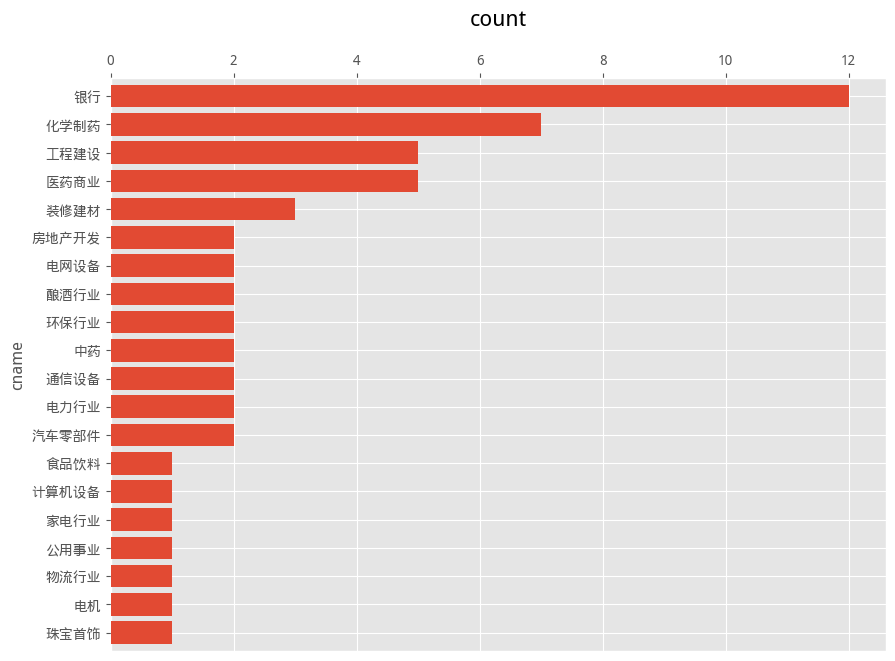

total: 64 | from 1.46 to 0.64


,1,2,3,4,5,6,7,8,9,10
0,招商银行,卧龙电驱,南京银行,华东医药,国药一致,九州通,海格通信,海康威视,老板电器,老凤祥
1,中国建筑,宁波华翔,嘉事堂,华夏银行,中信银行,豪迈科技,华海药业,华特达因,北京利尔,京新药业
2,南京医药,宁波建工,普洛药业,索菲亚,北京银行,兴业银行,交通银行,伟星新材,国电南瑞,物产中大
3,平安银行,保利发展,兴蓉环境,福能股份,农业银行,龙净环保,富安娜,光大银行,安徽建工,中国国贸
4,中国银行,丰原药业,汤臣倍健,洋河股份,三七互娱,贵州茅台,顺络电子,林洋能源,国投电力,瀚蓝环境
5,中天科技,联环药业,白云山,中国铁建,国药股份,江苏神通,建设银行,中国中铁,拓尔思,正泰电器
6,银轮股份,同仁堂,福耀玻璃,北部湾港,,,,,,


slope top 300 in all cols: 16
total: 12 | top 20 : 100.00%


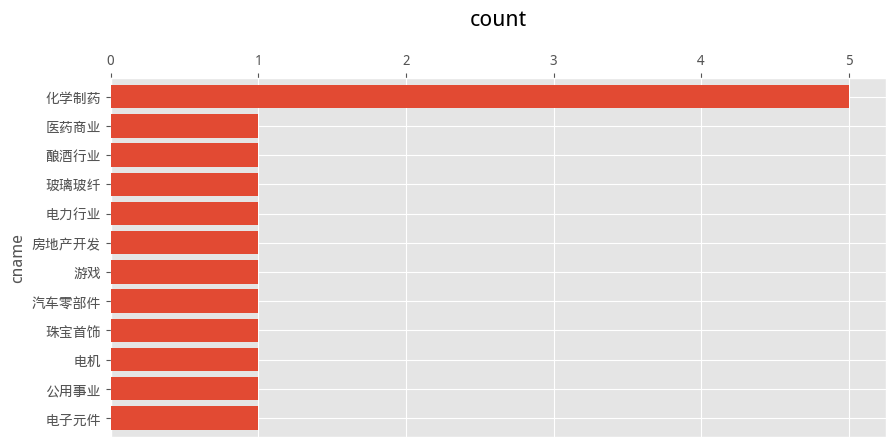

total: 16 | from 1.45 to 0.64


,1,2,3,4,5,6,7,8,9,10
0,卧龙电驱,华东医药,国药一致,老凤祥,宁波华翔,华海药业,华特达因,京新药业,普洛药业,兴蓉环境
1,中国国贸,三七互娱,贵州茅台,顺络电子,国投电力,福耀玻璃,,,,


In [ ]:
inc = q1tops[3]()

- 巨头还是比较多。但这个指标找出来一些至少在图上比较好看的公司。

## 金额和增长
- 不计算cash, 金额每年都进入前300, 增长也进入前300。

total: 17 | from 15 to 15
total: 4 | top 20 : 100.00%


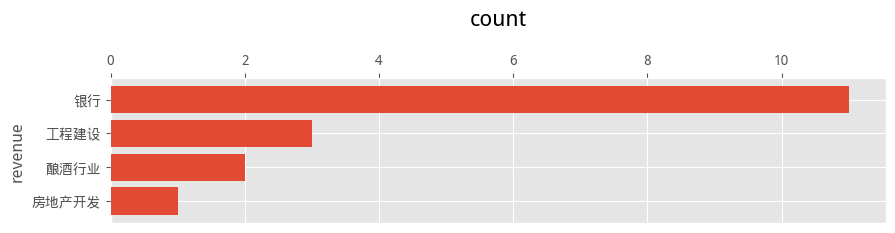

In [ ]:
yjbb.fold_a_col(cross_index([amount, inc]).iloc[:,0], show_num=False)
yjbb.indu_count(cross_index([amount, inc]).index)

- 各种指标的体量大，同时增长率也较好的公司很少，这个列表没什么惊喜。

In [ ]:
import nbformat as nbf
from pathlib import Path
def remove_input():
    fn = Path('2024q2.ipynb')
    nb = nbf.read(fn, nbf.NO_CONVERT)
    for cell in nb.cells:
        cell_tags = cell.get('metadata', {}).get('tags', [])
        if not 'remove_input' in cell_tags:
            cell_tags.append('remove_input')
            cell['metadata']['tags'] = cell_tags
    nbf.write(nb, fn)
remove_input()